In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip "/content/drive/MyDrive/kaggle/intel_classification/intel_imageclassification.zip" -d "/content/drive/MyDrive/kaggle/intel_classification/"

Streaming output truncated to the last 5000 lines.
  inflating: /content/drive/MyDrive/kaggle/intel_classification/seg_train/seg_train/mountain/7506.jpg  
  inflating: /content/drive/MyDrive/kaggle/intel_classification/seg_train/seg_train/mountain/7537.jpg  
  inflating: /content/drive/MyDrive/kaggle/intel_classification/seg_train/seg_train/mountain/7539.jpg  
  inflating: /content/drive/MyDrive/kaggle/intel_classification/seg_train/seg_train/mountain/7551.jpg  
  inflating: /content/drive/MyDrive/kaggle/intel_classification/seg_train/seg_train/mountain/7560.jpg  
  inflating: /content/drive/MyDrive/kaggle/intel_classification/seg_train/seg_train/mountain/7565.jpg  
  inflating: /content/drive/MyDrive/kaggle/intel_classification/seg_train/seg_train/mountain/7578.jpg  
  inflating: /content/drive/MyDrive/kaggle/intel_classification/seg_train/seg_train/mountain/7581.jpg  
  inflating: /content/drive/MyDrive/kaggle/intel_classification/seg_train/seg_train/mountain/7586.jpg  
  inflating: 

In [ ]:
import os
for dirname, _, filenames in os.walk('/content/drive/MyDrive/kaggle/intel_classification'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [ ]:
class_names = ['mountain', 'street', 'glacier', 'buildings', 'sea', 'forest']
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}

nb_classes = len(class_names)

IMAGE_SIZE = (150, 150)

In [ ]:
import numpy as np
import os
from sklearn.metrics import confusion_matrix
import seaborn as sn; sn.set(font_scale=1.4)
from sklearn.utils import shuffle           
import matplotlib.pyplot as plt             
import cv2                                 
import tensorflow as tf                
from tqdm import tqdm

In [ ]:
def load_data():

    
    datasets = ['/content/drive/MyDrive/kaggle/intel_classification/seg_train/seg_train', '/content/drive/MyDrive/kaggle/intel_classification/seg_test/seg_test']
    output = []
    
    # Iterate through training and test sets
    for dataset in datasets:
        
        images = []
        labels = []
        
        print("Loading {}".format(dataset))
        
        # Iterate through each folder corresponding to a category
        for folder in os.listdir(dataset):
            label = class_names_label[folder]
            
            # Iterate through each image in our folder
            for file in tqdm(os.listdir(os.path.join(dataset, folder))):
                
                # Get the path name of the image
                img_path = os.path.join(os.path.join(dataset, folder), file)
                
                # Open and resize the img
                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, IMAGE_SIZE) 
                
                # Append the image and its corresponding label to the output
                images.append(image)
                labels.append(label)
                
        images = np.array(images, dtype = 'float32')
        labels = np.array(labels, dtype = 'int32')   
        
        output.append((images, labels))

    return output



In [ ]:
(train_images, train_labels), (test_images, test_labels) = load_data()

Loading /content/drive/MyDrive/kaggle/intel_classification/seg_train/seg_train


100%|██████████| 2382/2382 [00:13<00:00, 175.39it/s]


Loading /content/drive/MyDrive/kaggle/intel_classification/seg_test/seg_test


100%|██████████| 501/501 [00:02<00:00, 189.38it/s]


In [ ]:
train_images, train_labels = shuffle(train_images, train_labels, random_state=25)

In [ ]:
n_train = train_labels.shape[0]
n_test = test_labels.shape[0]

print ("Number of training examples: {}",n_train)
print ("Number of testing examples: {}",n_test)
print ("Each image is of size: {}",IMAGE_SIZE)

Number of training examples: {} 14034
Number of testing examples: {} 3000
Each image is of size: {} (150, 150)


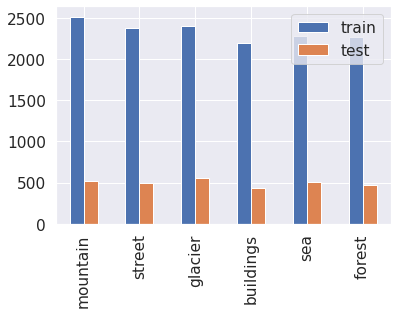

In [ ]:
import pandas as pd

_, train_counts = np.unique(train_labels, return_counts=True)
_, test_counts = np.unique(test_labels, return_counts=True)
pd.DataFrame({'train': train_counts,
                    'test': test_counts}, 
             index=class_names
            ).plot.bar()
plt.show()

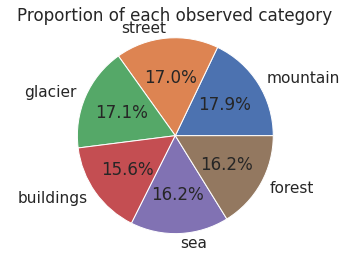

In [ ]:
plt.pie(train_counts,
        explode=(0, 0, 0, 0, 0, 0) , 
        labels=class_names,
        autopct='%1.1f%%')
plt.axis('equal')
plt.title('Proportion of each observed category')
plt.show()

In [ ]:
train_images = train_images / 255.0 
test_images = test_images / 255.0

In [ ]:
def display_random_image(class_names, images, labels):
    """
        Display a random image from the images array and its correspond label from the labels array.
    """
    
    index = np.random.randint(images.shape[0])
    plt.figure()
    plt.imshow(images[index])
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title('Image #{} : '.format(index) + class_names[labels[index]])
    plt.show()

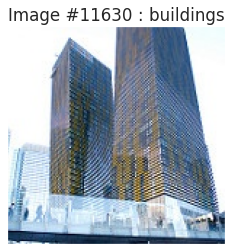

In [ ]:
display_random_image(class_names, train_images, train_labels)


In [ ]:
def display_examples(class_names, images, labels):
    """
        Display 25 images from the images array with its corresponding labels
    """
    
    fig = plt.figure(figsize=(10,10))
    fig.suptitle("Some examples of images of the dataset", fontsize=16)
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.binary)
        plt.xlabel(class_names[labels[i]])
    plt.show()

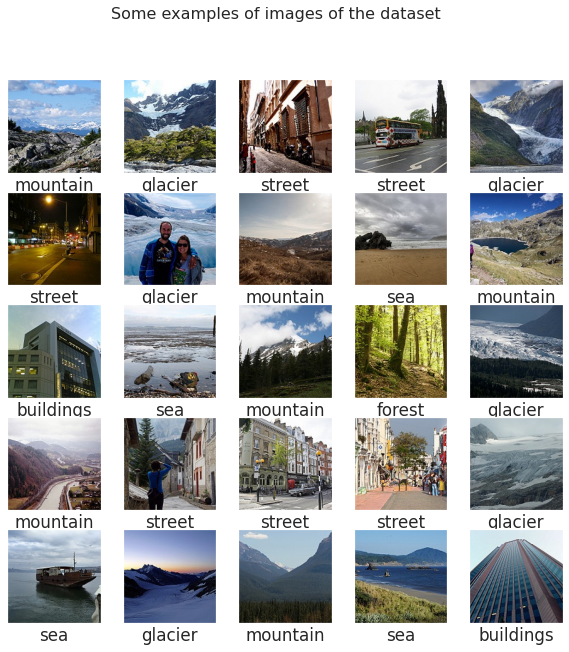

In [ ]:
display_examples(class_names, train_images, train_labels)

Steps are:

Build the model,
Compile the model,
Train / fit the data to the model,
Evaluate the model on the testing set,
Carry out an error analysis of our model.
We can build an easy model composed of different layers such as:

Conv2D: (32 filters of size 3 by 3) The features will be "extracted" from the image.
MaxPooling2D: The images get half sized.
Flatten: Transforms the format of the images from a 2d-array to a 1d-array of 150 150 3 pixel values.
Relu : given a value x, returns max(x, 0).
Softmax: 6 neurons, probability that the image belongs to one of the classes.

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (150, 150, 3)), 
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(6, activation=tf.nn.softmax)
])

In [ ]:
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(train_images, train_labels, batch_size=128, epochs=20, validation_split = 0.2)

Epoch 1/20
88/88 [==============================] - 268s 3s/step - loss: 1.2598 - accuracy: 0.5391 - val_loss: 0.8955 - val_accuracy: 0.6576
Epoch 2/20
88/88 [==============================] - 267s 3s/step - loss: 0.7939 - accuracy: 0.7115 - val_loss: 0.7930 - val_accuracy: 0.6908
Epoch 3/20
88/88 [==============================] - 268s 3s/step - loss: 0.6307 - accuracy: 0.7743 - val_loss: 0.7495 - val_accuracy: 0.7268
Epoch 4/20
88/88 [==============================] - 271s 3s/step - loss: 0.5026 - accuracy: 0.8237 - val_loss: 0.7425 - val_accuracy: 0.7332
Epoch 5/20
88/88 [==============================] - 277s 3s/step - loss: 0.3851 - accuracy: 0.8692 - val_loss: 0.6952 - val_accuracy: 0.7595
Epoch 6/20
88/88 [==============================] - 272s 3s/step - loss: 0.2707 - accuracy: 0.9139 - val_loss: 0.7534 - val_accuracy: 0.7631
Epoch 7/20
88/88 [==============================] - 278s 3s/step - loss: 0.1830 - accuracy: 0.9459 - val_loss: 0.8117 - val_accuracy: 0.7631
Epoch 8/20
88

In [ ]:
def plot_accuracy_loss(history):
    """
        Plot the accuracy and the loss during the training of the nn.
    """
    fig = plt.figure(figsize=(10,5))

    # Plot accuracy
    plt.subplot(221)
    plt.plot(history.history['accuracy'],'bo--', label = "accuracy")
    plt.plot(history.history['val_accuracy'], 'ro--', label = "val_accuracy")
    plt.title("train_accuracy vs val_accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epochs")
    plt.legend()

    # Plot loss function
    plt.subplot(222)
    plt.plot(history.history['loss'],'bo--', label = "loss")
    plt.plot(history.history['val_loss'], 'ro--', label = "val_loss")
    plt.title("train_loss vs val_loss")
    plt.ylabel("loss")
    plt.xlabel("epochs")

    plt.legend()
    plt.show()

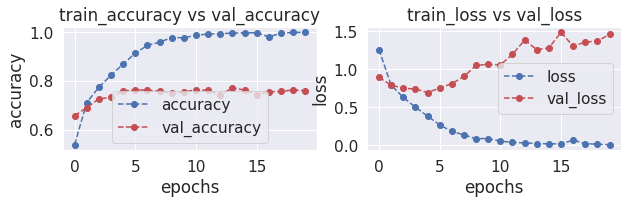

In [ ]:
plot_accuracy_loss(history)

In [ ]:
test_loss = model.evaluate(test_images, test_labels)


94/94 [==============================] - 19s 201ms/step - loss: 1.4366 - accuracy: 0.7443


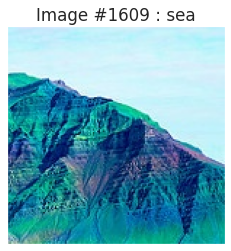

In [ ]:
predictions = model.predict(test_images)     # Vector of probabilities
pred_labels = np.argmax(predictions, axis = 1) # We take the highest probability

display_random_image(class_names, test_images, pred_labels)

In [ ]:
def print_mislabeled_images(class_names, test_images, test_labels, pred_labels):
    """
        Print 25 examples of mislabeled images by the classifier, e.g when test_labels != pred_labels
    """
    BOO = (test_labels == pred_labels)
    mislabeled_indices = np.where(BOO == 0)
    mislabeled_images = test_images[mislabeled_indices]
    mislabeled_labels = pred_labels[mislabeled_indices]

    title = "Some examples of mislabeled images by the classifier:"
    display_examples(class_names,  mislabeled_images, mislabeled_labels)

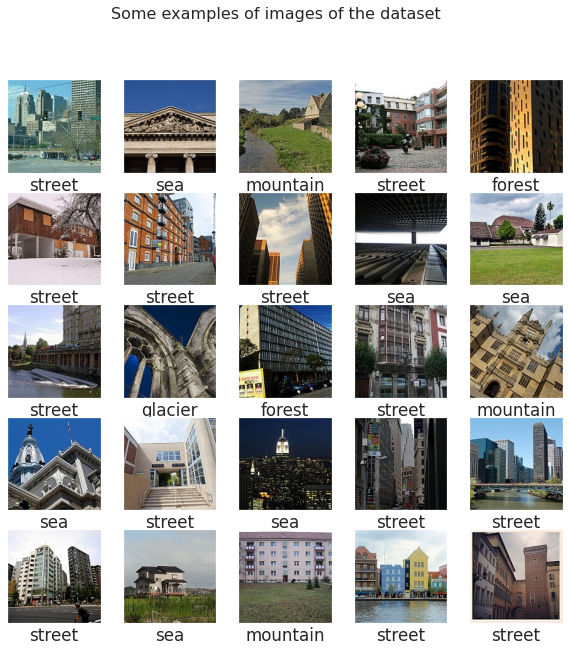

In [ ]:
print_mislabeled_images(class_names, test_images, test_labels, pred_labels)


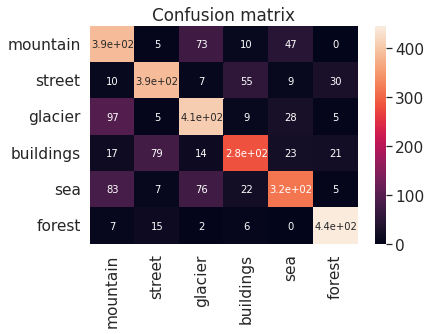

In [ ]:
CM = confusion_matrix(test_labels, pred_labels)
ax = plt.axes()
sn.heatmap(CM, annot=True, 
           annot_kws={"size": 10}, 
           xticklabels=class_names, 
           yticklabels=class_names, ax = ax)
ax.set_title('Confusion matrix')
plt.show()

In [ ]:
#VGG
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input

model = VGG16(weights='imagenet', include_top=False)

58900480/58889256 [==============================] - 1s 0us/step


In [ ]:
train_features = model.predict(train_images)
test_features = model.predict(test_images)

In [ ]:
n_train, x, y, z = train_features.shape
n_test, x, y, z = test_features.shape
numFeatures = x * y * z

from sklearn import decomposition

pca = decomposition.PCA(n_components = 2)

X = train_features.reshape((n_train, x*y*z))
pca.fit(X)

C = pca.transform(X) # Représentation des individus dans les nouveaux axe
C1 = C[:,0]
C2 = C[:,1]

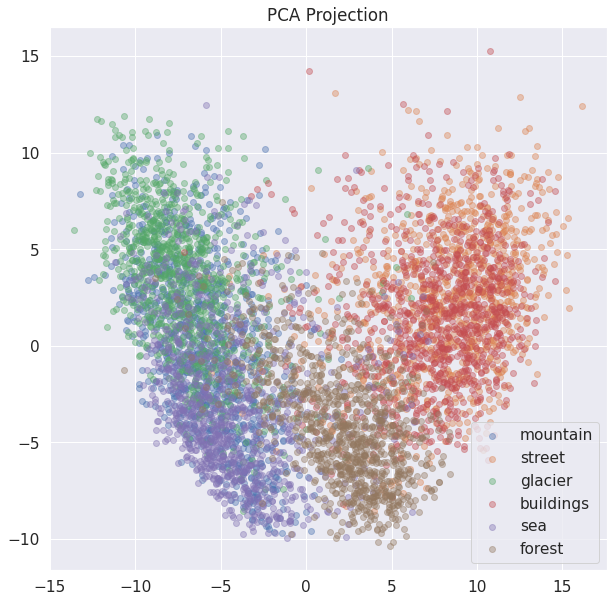

In [ ]:
### Figures

plt.subplots(figsize=(10,10))

for i, class_name in enumerate(class_names):
    plt.scatter(C1[train_labels == i][:1000], C2[train_labels == i][:1000], label = class_name, alpha=0.4)
plt.legend()
plt.title("PCA Projection")
plt.show()